In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
%matplotlib inline

from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
dados = "/content/drive/My Drive/ColabNotebooks/Projetos Portifolio/Prevendo_valor_acoes/itausa.csv"

In [3]:
dados = pd.read_csv(dados)
dados.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,1.01835,1.14360,1.01290,1.08370,0.620248,10285107.0
1,2000-01-04,1.04558,1.04558,0.98023,0.98023,0.561028,12071740.0
2,2000-01-05,0.98568,1.06192,0.94756,1.06192,0.607783,9163033.0
3,2000-01-06,1.05647,1.08370,1.05102,1.07825,0.617129,23085841.0
4,2000-01-07,1.08914,1.10548,1.06192,1.07281,0.614016,11216095.0


In [4]:
dados['Date'] = pd.to_datetime(dados['Date'])
dados.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

In [5]:
valores_nulos = dados.isnull().sum()
valores_nulos

Date          0
Open         87
High         87
Low          87
Close        87
Adj Close    87
Volume       87
dtype: int64

In [6]:
dados.shape

(5152, 7)

In [7]:
dados_nulos = dados[dados['Close'].isnull() == True].index
dados_nulos

Int64Index([ 255,  260,  278,  300,  301,  334,  346,  347,  352,  367,  378,
             392,  395,  439,  450,  464,  479,  488,  515,  516,  520,  521,
             539,  550,  551,  563,  584,  607,  628,  656,  749,  776,  777,
             781,  782,  825,  826,  859,  860,  868,  903,  917, 1037, 1038,
            1042, 1043, 1080, 1081, 1114, 1122, 1124, 1158, 1179, 1221, 1246,
            1261, 1270, 1299, 1304, 1571, 1594, 1595, 1628, 1633, 1639, 1672,
            1732, 1757, 1772, 1781, 1784, 2434, 2553, 2827, 2838, 2845, 2862,
            2864, 3004, 3005, 3006, 3015, 3036, 3061, 4569, 4828, 5071],
           dtype='int64')

In [8]:
for i in dados_nulos:
  ope = ((dados['Open'].iloc[i-1] + dados['Open'].iloc[i-1]) / 2)	
  high = ((dados['High'].iloc[i-1] + dados['High'].iloc[i-1]) / 2)	
  low = ((dados['Low'].iloc[i-1] + dados['Low'].iloc[i-1]) / 2)	
  close = ((dados['Close'].iloc[i-1] + dados['Close'].iloc[i-1]) / 2)
  aclose = ((dados['Adj Close'].iloc[i-1] + dados['Adj Close'].iloc[i-1]) / 2)	
  volume = ((dados['Volume'].iloc[i-1] + dados['Volume'].iloc[i-1]) / 2)
  
  dados['Open'].iloc[i] = ope
  dados['High'].iloc[i] = high
  dados['Low'].iloc[i] = low
  dados['Close'].iloc[i] = close
  dados['Adj Close'].iloc[i] = aclose
  dados['Volume'].iloc[i] = volume

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
dados.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
dados.drop(['High', 'Low', 'Open', 'Adj Close'], axis = 1, inplace=True)

In [11]:
listofNum = list(filter(lambda i: i%200==0, [a for a in range(dados.shape[0])]))
x = dados['Date'].iloc[listofNum]
x = x.append(dados['Date'].tail(1))
x = np.array(x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


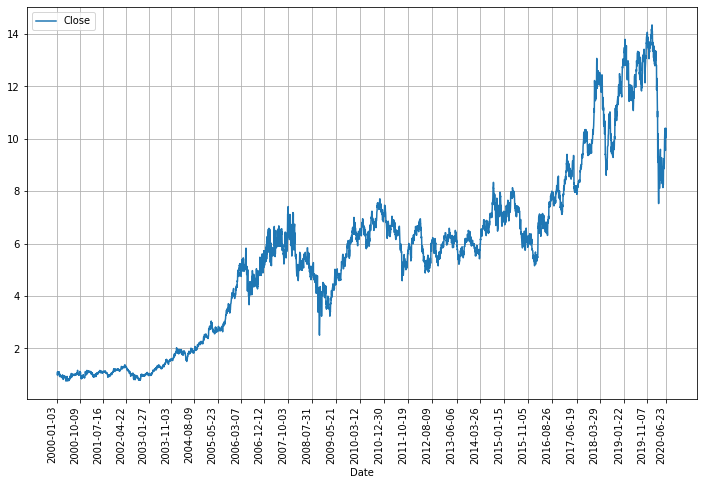

In [12]:
dados.plot(x='Date', y='Close', figsize=(12,8))   
plt.xticks(x, rotation='vertical')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [13]:
dados.dtypes

Date      datetime64[ns]
Close            float64
Volume           float64
dtype: object

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


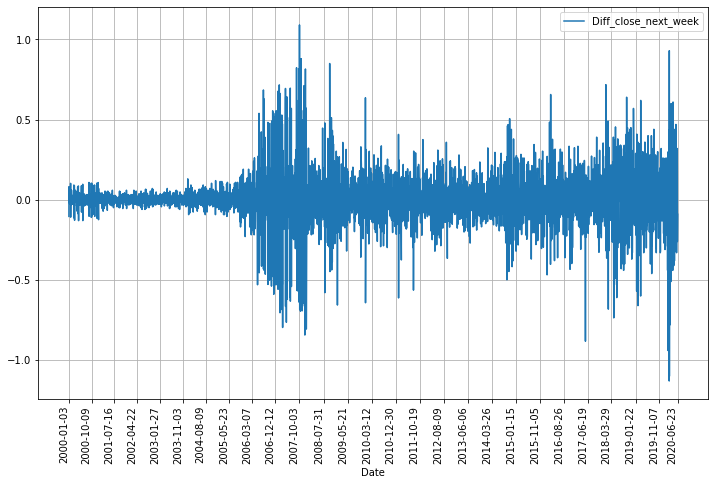

In [14]:
def target_diff(x):
    return x.diff().shift(-1)

dados['Diff_close_next_week'] = target_diff(dados['Close'])

dados.plot(x='Date', y='Diff_close_next_week', figsize=(12,8))   
plt.xticks(x, rotation='vertical')
plt.axes().yaxis.grid()
plt.axes().xaxis.grid()
plt.show()

In [38]:
train = dados[dados['Date'] < '2009-05-21'].copy()
valid = dados[dados['Date'] >= '2009-05-21'].copy()
train.shape, valid.shape

((2400, 4), (2752, 4))

In [39]:
y_treino = train['Close']
y_valid = valid['Close']

In [40]:
#baseline
baseline_treino = train['Close'].shift(1)
baseline_valid = valid['Close'].shift(1)
train['baseline'] = baseline_treino
valid['baseline'] = baseline_valid

In [41]:
print("Erro:",round(np.sqrt(mean_squared_log_error(y_valid[baseline_valid.notnull()], 
                            baseline_valid[baseline_valid.notnull()]))*100, 2),"%")

Erro: 1.74 %


In [42]:
train['Day'] = train['Date'].dt.day
train['Mouth'] = train['Date'].dt.month
#train['Years_day'] = train['Date'].dt.dayofyear
train['Weeks_day'] = train['Date'].dt.weekday
#train['Week'] = train['Date'].dt.week
train.drop('baseline', axis = 1, inplace=True)

In [43]:
valid['Day'] = valid['Date'].dt.day
valid['Mouth'] = valid['Date'].dt.month
#valid['Years_day'] = valid['Date'].dt.dayofyear
valid['Weeks_day'] = valid['Date'].dt.weekday
#valid['Week'] = valid['Date'].dt.week
valid.drop('baseline', axis = 1, inplace=True)

In [44]:
for i in range(0, 30):
  train['Average_close_price_{}'.format(i)] = train['Close'].shift(i)
  valid['Average_close_price_{}'.format(i)] = valid['Close'].shift(i)

In [45]:
for i in range(1, 30):
  train['Diff_avarage_close_price_{}'.format(i)] = train['Close'].diff(i)
  valid['Diff_avarage_close_price_{}'.format(i)] = valid['Close'].diff(i)

In [46]:
for i in range(2, 30):
  train['Moving_avarage_close_price_{}_weeks'.format(i)] = train['Close'].rolling(i).mean().reset_index(level=0, drop=True)
  valid['Moving_avarage_close_price_{}_weeks'.format(i)] = valid['Close'].rolling(i).mean().reset_index(level=0, drop=True)

In [47]:
train = train.dropna()
valid = valid.dropna()

In [48]:
train.head()

,Date,Close,Volume,Diff_close_next_week,Day,Mouth,Weeks_day,Average_close_price_0,Average_close_price_1,Average_close_price_2,Average_close_price_3,Average_close_price_4,Average_close_price_5,Average_close_price_6,Average_close_price_7,Average_close_price_8,Average_close_price_9,Average_close_price_10,Average_close_price_11,Average_close_price_12,Average_close_price_13,Average_close_price_14,Average_close_price_15,Average_close_price_16,Average_close_price_17,Average_close_price_18,Average_close_price_19,Average_close_price_20,Average_close_price_21,Average_close_price_22,Average_close_price_23,Average_close_price_24,Average_close_price_25,Average_close_price_26,Average_close_price_27,Average_close_price_28,Average_close_price_29,Diff_avarage_close_price_1,Diff_avarage_close_price_2,Diff_avarage_close_price_3,...,Diff_avarage_close_price_18,Diff_avarage_close_price_19,Diff_avarage_close_price_20,Diff_avarage_close_price_21,Diff_avarage_close_price_22,Diff_avarage_close_price_23,Diff_avarage_close_price_24,Diff_avarage_close_price_25,Diff_avarage_close_price_26,Diff_avarage_close_price_27,Diff_avarage_close_price_28,Diff_avarage_close_price_29,Moving_avarage_close_price_2_weeks,Moving_avarage_close_price_3_weeks,Moving_avarage_close_price_4_weeks,Moving_avarage_close_price_5_weeks,Moving_avarage_close_price_6_weeks,Moving_avarage_close_price_7_weeks,Moving_avarage_close_price_8_weeks,Moving_avarage_close_price_9_weeks,Moving_avarage_close_price_10_weeks,Moving_avarage_close_price_11_weeks,Moving_avarage_close_price_12_weeks,Moving_avarage_close_price_13_weeks,Moving_avarage_close_price_14_weeks,Moving_avarage_close_price_15_weeks,Moving_avarage_close_price_16_weeks,Moving_avarage_close_price_17_weeks,Moving_avarage_close_price_18_weeks,Moving_avarage_close_price_19_weeks,Moving_avarage_close_price_20_weeks,Moving_avarage_close_price_21_weeks,Moving_avarage_close_price_22_weeks,Moving_avarage_close_price_23_weeks,Moving_avarage_close_price_24_weeks,Moving_avarage_close_price_25_weeks,Moving_avarage_close_price_26_weeks,Moving_avarage_close_price_27_weeks,Moving_avarage_close_price_28_weeks,Moving_avarage_close_price_29_weeks
29,2000-02-11,0.94756,4320642.0,-0.02179,11,2,4,0.94756,0.97478,0.98023,1.00746,1.01290,0.95300,0.94211,0.94756,0.94756,0.92577,0.95845,0.98568,0.99657,1.10464,1.00201,1.02380,1.04558,1.06736,1.07825,1.10548,1.06736,1.06192,1.08370,1.10548,1.11093,1.07281,1.07825,1.06192,0.98023,1.08370,-0.02722,-0.03267,-0.05990,...,-0.13069,-0.15792,-0.11980,-0.11436,-0.13614,-0.15792,-0.16337,-0.12525,-0.13069,-0.11436,-0.03267,-0.13614,0.961170,0.967523,0.977507,0.984586,0.979322,0.974006,0.970700,0.968129,0.963893,0.963398,0.965255,0.967664,0.977448,0.979085,0.981880,0.985627,0.990168,0.994804,1.000337,1.003529,1.006183,1.009553,1.013550,1.017446,1.019575,1.021748,1.023183,1.021702
30,2000-02-14,0.92577,5479479.0,-0.01089,14,2,0,0.92577,0.94756,0.97478,0.98023,1.00746,1.01290,0.95300,0.94211,0.94756,0.94756,0.92577,0.95845,0.98568,0.99657,1.10464,1.00201,1.02380,1.04558,1.06736,1.07825,1.10548,1.06736,1.06192,1.08370,1.10548,1.11093,1.07281,1.07825,1.06192,0.98023,-0.02179,-0.04901,-0.05446,...,-0.14159,-0.15248,-0.17971,-0.14159,-0.13615,-0.15793,-0.17971,-0.18516,-0.14704,-0.15248,-0.13615,-0.05446,0.936665,0.949370,0.957085,0.967160,0.974783,0.971671,0.967976,0.965708,0.963893,0.960427,0.960262,0.962218,0.964671,0.974003,0.975753,0.978579,0.982302,0.986778,0.991352,0.996787,0.999995,1.002687,1.006062,1.010039,1.013920,1.016101,1.018320,1.019824
31,2000-02-15,0.91488,6873234.0,0.02723,15,2,1,0.91488,0.92577,0.94756,0.97478,0.98023,1.00746,1.01290,0.95300,0.94211,0.94756,0.94756,0.92577,0.95845,0.98568,0.99657,1.10464,1.00201,1.02380,1.04558,1.06736,1.07825,1.10548,1.06736,1.06192,1.08370,1.10548,1.11093,1.07281,1.07825,1.06192,-0.01089,-0.03268,-0.05990,...,-0.13070,-0.15248,-0.16337,-0.19060,-0.15248,-0.14704,-0.16882,-0.19060,-0.19605,-0.15793,-0.16337,-0.14704,0.920325,0.929403,0.940747,0.948644,0.958447,0.966226,0

In [49]:
train.drop(['Date', 'Close'], axis = 1, inplace=True)
valid.drop(['Date', 'Close'], axis=1, inplace=True)

In [50]:
X_train, y_train = train.drop('Diff_close_next_week', axis=1), train['Diff_close_next_week']
X_valid, y_valid = valid.drop('Diff_close_next_week', axis=1), valid['Diff_close_next_week']
y_valid_f = X_valid['Average_close_price_0'] + y_valid

In [28]:
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=0,
                              n_estimators=1500,
                              min_samples_leaf=264,
                              max_features='auto')

model.fit(X_train, y_train)
p = model.predict(X_valid)

p_final = X_valid['Average_close_price_0'] + p
print("Erro:",round(np.sqrt(mean_squared_log_error(y_valid_f, p_final))*100, 2),"%")

Erro: 1.77 %


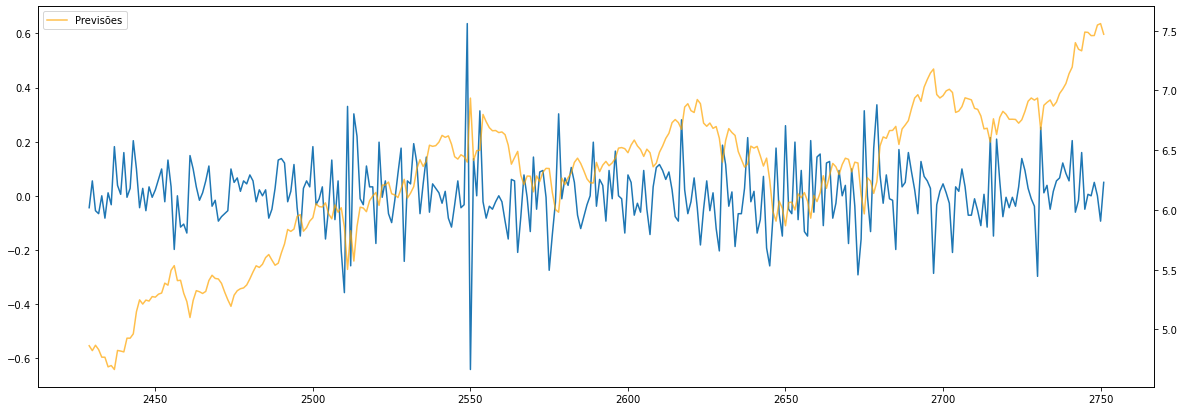

In [29]:
fig, ax = pylab.subplots(1, 1, figsize = (20, 7))
ax.plot(y_valid, label='Y')
axt = ax.twinx()
axt.plot(p_final, color='orange', alpha=0.7, label='Previsões')
axt.legend()

In [58]:
model = lgb.LGBMRegressor(n_jobs=-1, 
                          random_state=0, 
                          n_estimators=1000, 
                          learning_rate=0.0001, 
                          num_leaves=2**4, 
                          subsample=0.1, 
                          subsample_freq=1)
model.fit(X_train, y_train)
p = model.predict(X_valid)
p_final = X_valid['Average_close_price_0'] + p

print("Erro:",round(np.sqrt(mean_squared_log_error(y_valid_f, p_final))*100, 2),"%")

Erro: 1.7 %


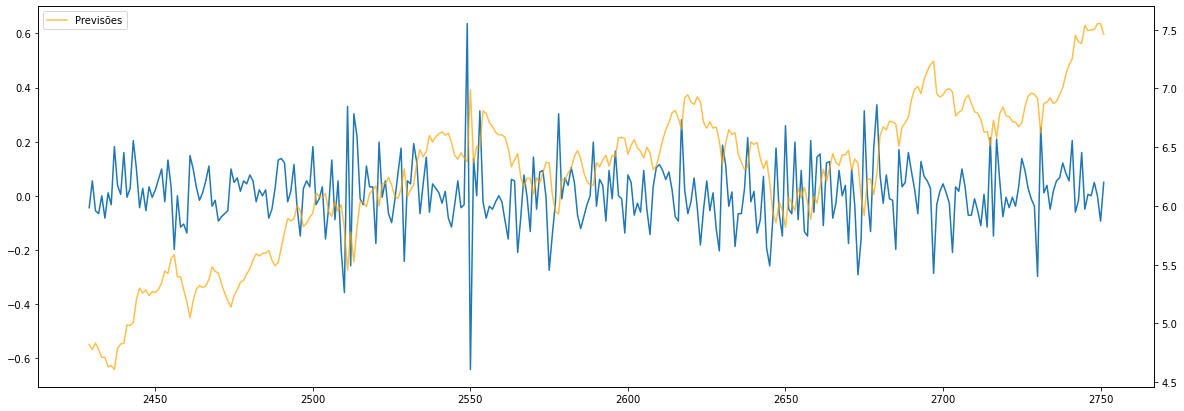

In [31]:
fig, ax = pylab.subplots(1, 1, figsize=(20,7))
ax.plot(y_valid, label = 'Y')
axt = ax.twinx()
axt.plot(p_final, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()

In [32]:
accept = []
vl_low_error = 10000

for step in range(20):
    var_low_error = None
    for var in X_train.columns:
        if var in accept:
            continue
        mdl.fit(X_train[accept+[var]], y_train)
        p = mdl.predict(X_valid[accept+[var]])

        p_final = X_valid['Average_close_price_0'] + p
        y_valid_f = X_valid['Average_close_price_0'] + y_valid

        error = np.sqrt(mean_squared_log_error(y_valid_f, p_final)) * 100

        if erro < vl_low_error:
            var_low_error = var
            vl_low_error = error
    if var_low_error is None:
        break
    accept.append(var_low_error)
        
    print("Melhor Variável: {} - Erro: {:.4f}\n".format(var_low_error, vl_low_error))
    print(accept)
    print()

Melhor Variável: Diff_avarage_close_price_10 - Erro: 1.7022

['Diff_avarage_close_price_10']

Melhor Variável: Diff_avarage_close_price_2 - Erro: 1.7014

['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2']

Melhor Variável: Moving_avarage_close_price_7_weeks - Erro: 1.7003

['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2', 'Moving_avarage_close_price_7_weeks']

Melhor Variável: Diff_avarage_close_price_13 - Erro: 1.6984

['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2', 'Moving_avarage_close_price_7_weeks', 'Diff_avarage_close_price_13']

Melhor Variável: Diff_avarage_close_price_7 - Erro: 1.6977

['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2', 'Moving_avarage_close_price_7_weeks', 'Diff_avarage_close_price_13', 'Diff_avarage_close_price_7']

Melhor Variável: Diff_avarage_close_price_15 - Erro: 1.6972

['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2', 'Moving_avarage_close_price_7_weeks', 'Diff_avarage_close_price_13', 'Diff_a

In [51]:
columns = ['Diff_avarage_close_price_10', 'Diff_avarage_close_price_2', 'Moving_avarage_close_price_7_weeks', 
           'Diff_avarage_close_price_13', 'Diff_avarage_close_price_7', 'Diff_avarage_close_price_15', 'Mouth', 
           'Diff_avarage_close_price_12', 'Diff_avarage_close_price_24', 'Moving_avarage_close_price_3_weeks', 
           'Moving_avarage_close_price_19_weeks', 'Moving_avarage_close_price_4_weeks', 'Moving_avarage_close_price_14_weeks', 
           'Moving_avarage_close_price_10_weeks', 'Moving_avarage_close_price_5_weeks', 'Volume', 'Moving_avarage_close_price_11_weeks',
           'Average_close_price_0', 'Diff_close_next_week']

In [52]:
train = train[colunas]
train.head()

,Diff_avarage_close_price_10,Diff_avarage_close_price_2,Moving_avarage_close_price_7_weeks,Diff_avarage_close_price_13,Diff_avarage_close_price_7,Diff_avarage_close_price_15,Mouth,Diff_avarage_close_price_12,Diff_avarage_close_price_24,Moving_avarage_close_price_3_weeks,Moving_avarage_close_price_19_weeks,Moving_avarage_close_price_4_weeks,Moving_avarage_close_price_14_weeks,Moving_avarage_close_price_10_weeks,Moving_avarage_close_price_5_weeks,Volume,Moving_avarage_close_price_11_weeks,Average_close_price_0,Diff_close_next_week
29,-0.01089,-0.03267,0.974006,-0.15708,0.00000,-0.07624,2,-0.04901,-0.16337,0.967523,0.994804,0.977507,0.977448,0.963893,0.984586,4320642.0,0.963398,0.94756,-0.02179
30,0.00000,-0.04901,0.971671,-0.07080,-0.01634,-0.07624,2,-0.05991,-0.17971,0.949370,0.986778,0.957085,0.964671,0.963893,0.967160,5479479.0,0.960427,0.92577,-0.01089
31,-0.03268,-0.03268,0.966226,-0.07080,-0.03812,-0.18976,2,-0.04357,-0.16882,0.929403,0.978753,0.940747,0.958836,0.960625,0.948644,6873234.0,0.959437,0.91488,0.02723
32,-0.00545,0.01634,0.956113,-0.01634,-0.07079,-0.05446,2,0.01634,-0.11981,0.927587,0.973307,0.932580,0.955724,0.960080,0.941020,12359984.0,0.958942,0.94211,0.01089
33,0.01089,0.03812,0.948333,0.02723,-0.05446,-0.03268,2,0.00544,-0.11436,0.936663,0.969581,0.933940,0.955335,0.961169,0.936664,6274525.0,0.959436,0.95300,-0.02178


In [53]:
valid = valid[colunas]

In [54]:
X_train, y_train = train.drop('Diff_close_next_week', axis=1), train['Diff_close_next_week']
X_valid, y_valid = valid.drop('Diff_close_next_week', axis=1), valid['Diff_close_next_week']
y_valid_f = X_valid['Average_close_price_0'] + y_valid

In [56]:
model = lgb.LGBMRegressor(n_jobs=-1, 
                          random_state=0, 
                          n_estimators=1000, 
                          learning_rate=0.0001, 
                          num_leaves=2**4, 
                          subsample=0.1, 
                          subsample_freq=1)
model.fit(X_train, y_train)
p = model.predict(X_valid)
p_final = X_valid['Average_close_price_0'] + p

print("Erro:",round(np.sqrt(mean_squared_log_error(y_valid_f, p_final))*100, 4),"%")

Erro: 1.6962 %


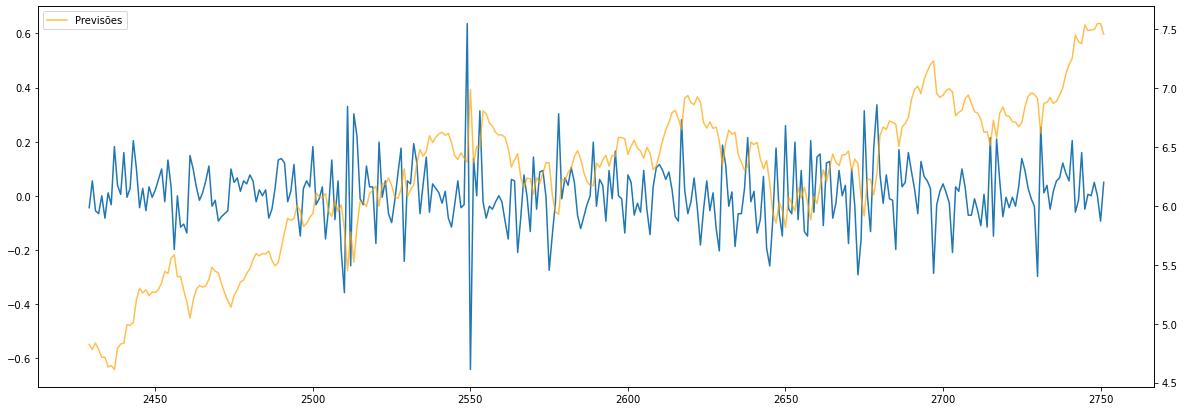

In [57]:
fig, ax = pylab.subplots(1, 1, figsize=(20,7))
ax.plot(y_valid, label = 'Y')
axt = ax.twinx()
axt.plot(p_final, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()